In [31]:
from lib import Augmentation_methods
from lib import data_preparation
from lib import vae_augmentation

import matplotlib.pyplot as plt
from scipy.signal import stft
import numpy as np
import pandas as pd
from pathlib import Path
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from IPython.display import clear_output
from tensorflow.keras.layers import MaxPooling2D ,Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D ,Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
BASEDIR = Path("/store/projects/fallki/")
FAKEDIR = BASEDIR / "Fake-Events" / "2. Fake-Events Messung"

# BASEDIR = pathlib.Path('/store/projects/fallki/')
# FAKEDIR = pathlib.Path('Fake-Events/2. Fake-Events Messung/')
df_fake = pd.read_parquet(BASEDIR / FAKEDIR / 'gSensoren_FakeEvents.parquet')

In [4]:
def SignalToSpectrum(signal, samplerate=1600):
    SIGNAL_LENGTH = samplerate * 10
    F = stft(signal[:SIGNAL_LENGTH], 1600, nperseg=128)[2]
    F = F[2:,]
    return np.expand_dims(np.abs(F), axis=2) # Add extra dimension for TF Conv2D

In [5]:
#To obtain the dummy data
dummy_lab_data = data_preparation.fake_lab_data()
dummy_data = dummy_lab_data[0]
dummy_dataframe =pd.DataFrame(dummy_data,columns=['z'])

/home/ing2146/Final/SNEHA/lib/data_preparation.py:202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  All_Events_Data = np.array(All_Events_Data)[shuffler]
/home/ing2146/Final/SNEHA/lib/data_preparation.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_fake_dummy_Data = np.array(df_fake_dummy_Data)


In [6]:
# Drop unrealistic negative values
index_list = []
for index,row in dummy_dataframe.iterrows():
    if row["z"][0] < 0:
        index_list.append(index)

dummy_data_df = dummy_dataframe.drop(index_list)

In [7]:
#To divide the extracted dummy df in the ratio specified
train_part = dummy_data_df.sample(frac = 0.60) 
test_part = dummy_data_df.drop(train_part.index) #test data

In [8]:
#reset the index
train_part.reset_index(drop=True, inplace=True)
test_part.reset_index(drop=True, inplace=True)

#### Augmentation of (n-k) dummy event using traditional methods

In [9]:
augmented_dummy = []

for i, event in enumerate(train_part.to_numpy().ravel()): 
    
    #Jittering
    Noise_dummy = Augmentation_methods.add_white_noise(event, 0.15) 
    augmented_dummy.append(Noise_dummy)
    
    #Jittering
    Noise_dummy1 = Augmentation_methods.add_white_noise(event, 0.12) 
    augmented_dummy.append(Noise_dummy1)
    
    #Jittering
    Noise_dummy2 = Augmentation_methods.add_white_noise(event, 0.08) 
    augmented_dummy.append(Noise_dummy2)
    
    #Jittering
    Noise_dummy2 = Augmentation_methods.add_white_noise(event, 0.05) 
    augmented_dummy.append(Noise_dummy2)
    
    #Magnitude Warping
    magnitude_warped_dummy =  Augmentation_methods.magnitudewarping(event,0.1, 20) 
    augmented_dummy.append(magnitude_warped_dummy[1])
    
    #Magnitude Warping
    magnitude_warped_dummy1 =  Augmentation_methods.magnitudewarping(event,0.1, 15) 
    augmented_dummy.append(magnitude_warped_dummy1[1])
    
    #Magnitude Warping
    magnitude_warped_dummy2 =  Augmentation_methods.magnitudewarping(event,0.1, 10) 
    augmented_dummy.append(magnitude_warped_dummy2[1])
    
    #Window Warping
    window_warped_dummy = Augmentation_methods.windowWarp(event, window_ratio=0.1, scales=[0.5, 2.]) 
    augmented_dummy.append(window_warped_dummy)
    
    #Jittering + Magnitude warping
    curve_JMW, jittered_magnitude_warped_dummy  =  Augmentation_methods.magnitudewarping((Augmentation_methods.add_white_noise(event, 0.50)),0.1, 10)
    augmented_dummy.append(jittered_magnitude_warped_dummy)
    
    #Jittering + window warping
    Jittered_window_warped_dummy = Augmentation_methods.windowWarp((Augmentation_methods.add_white_noise(event, 0.50)), window_ratio=0.1, scales=[0.5, 2.])
    augmented_dummy.append(Jittered_window_warped_dummy)
    
    #magnitude warping + window warping
    mag_warped  =  Augmentation_methods.magnitudewarping(event,0.1, 10)
    mag_window_warped_dummy = Augmentation_methods.windowWarp(mag_warped[1] , window_ratio=0.1, scales=[0.5, 2.])
    augmented_dummy.append(mag_window_warped_dummy)
          
    
augmented_dummy_array = np.array(augmented_dummy)    

/tmp/ipykernel_1396149/3983658721.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  augmented_dummy_array = np.array(augmented_dummy)


In [10]:
augmented_dummy_array_df =pd.DataFrame(augmented_dummy_array,columns=['z'])

## Data Preparation

### Traditional Augmented data 

In [11]:
M = []
for i in range(len(augmented_dummy_array_df)):
    M.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": len(augmented_dummy_array_df.z[i]),
              "spectrum": SignalToSpectrum(augmented_dummy_array_df.z[i])})
augmented_df = pd.DataFrame.from_dict(M)

In [12]:
# normalize the spectrum to facilitate training 
augmented_df["normalizedSpectrum"] = augmented_df["spectrum"] / augmented_df["spectrum"].map(np.max).max()

# shuffle the final dataframe
augmented_df = augmented_df.sample(frac=1).reset_index(drop=True)

### Dummy events (n-k) for training

In [13]:
T = []
for i in range(len(train_part)):
    T.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": len(train_part.z[i]),
              "spectrum": SignalToSpectrum(train_part.z[i])})
train_part_df = pd.DataFrame.from_dict(T)

In [14]:
# normalize the spectrum to facilitate training 
train_part_df["normalizedSpectrum"] = train_part_df["spectrum"] / train_part_df["spectrum"].map(np.max).max()

### VAE Augmentation

In [17]:
normalization_factor = train_part_df["spectrum"].map(np.max).max()

In [18]:
X_train_vae = np.stack(train_part_df["normalizedSpectrum"])
y_train_vae = train_part_df["istSturz"]

In [21]:
def sample_z(args):
        z_mean, z_log_var = args
        eps = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
        return z_mean + K.exp(z_log_var / 2) * eps

In [32]:
latent_dim = 2 # Number of latent dim parameters

# Encoder 
input_data = Input(shape=(63,251,1), name='encoder_input')
x = layers.Conv2D(32,3, padding='same', activation='relu')(input_data)
x = layers.Conv2D(64,3, padding='same', activation='relu')(x)
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_log_var = layers.Dense(latent_dim, name='latent_sigma')(x) 
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])
encoder = Model(input_data, [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2],conv_shape[3]))(x)
x = Conv2DTranspose(64,3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32,3, padding='same', activation='sigmoid')(x)
decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name='decoder_output')(x)
decoder = Model(decoder_input, decoder_output, name='decoder')

In [33]:
# Training VAE model with train data 
vae = vae_augmentation.VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam())
vae.fit(X_train_vae, epochs = 30,batch_size=9)

Epoch 1/30
5/5 [==============================] - 2s 328ms/step - loss: 8418.9583 - reconstruction_loss: 5969.3267 - kl_loss: 3959.6406
Epoch 2/30
5/5 [==============================] - 2s 330ms/step - loss: 3103.2696 - reconstruction_loss: 2654.2651 - kl_loss: 73.6684
Epoch 3/30
5/5 [==============================] - 2s 331ms/step - loss: 1469.5013 - reconstruction_loss: 1305.0718 - kl_loss: 1.0387
Epoch 4/30
5/5 [==============================] - 2s 329ms/step - loss: 626.0328 - reconstruction_loss: 518.9088 - kl_loss: 0.3220
Epoch 5/30
5/5 [==============================] - 2s 330ms/step - loss: 242.3720 - reconstruction_loss: 222.8680 - kl_loss: 3.5813
Epoch 6/30
5/5 [==============================] - 2s 342ms/step - loss: 221.5294 - reconstruction_loss: 214.1823 - kl_loss: 12.2670
Epoch 7/30
5/5 [==============================] - 2s 335ms/step - loss: 227.8330 - reconstruction_loss: 206.5026 - kl_loss: 17.8072
Epoch 8/30
5/5 [==============================] - 2s 339ms/step - loss:

2/2 [==============================] - 0s 21ms/step


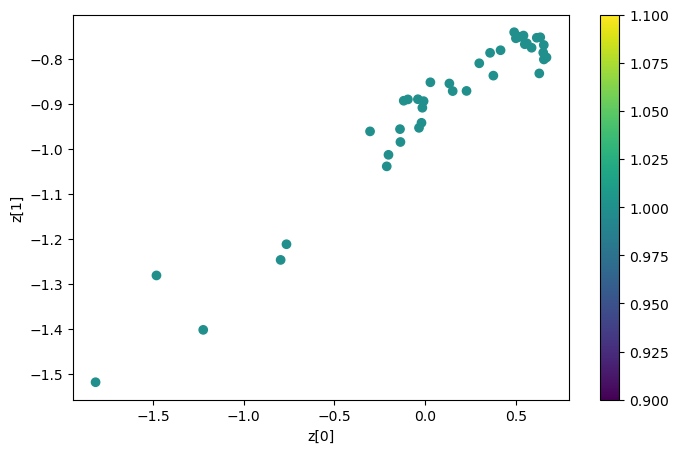

In [36]:
# predicting the distribution
z_mean, z_log_var, z = vae.encoder.predict(X_train_vae)
plt.figure(figsize=(8, 5))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=train_part_df["istSturz"])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [ ]:
# predicting usinbg decoder - Augmentation
augmented_data= vae_augmentation.plot_latent_space(vae, z_mean, decoder, n = 20)

In [39]:
augmented_data = np.expand_dims(np.array(augmented_data), axis=3)

In [40]:
V = []
for i in range(len(augmented_data)):
    V.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": 16000,
              "spectrum": normalization_factor * augmented_data[i],
              "normalizedSpectrum":augmented_data[i]})
vae_df = pd.DataFrame.from_dict(V)

In [42]:
vae_df

,event,istSturz,signalLenght,spectrum,normalizedSpectrum
0,Dummy,1,16000,"[[[87.29768], [26.930946], [14.435013], [7.653...","[[[0.24366497], [0.075169556], [0.040290955], ..."
1,Dummy,1,16000,"[[[87.31337], [26.92654], [14.428718], [7.6463...","[[[0.24370876], [0.07515726], [0.040273383], [..."
2,Dummy,1,16000,"[[[87.32767], [26.920841], [14.421605], [7.638...","[[[0.24374866], [0.075141355], [0.04025353], [..."
3,Dummy,1,16000,"[[[87.340385], [26.91452], [14.413931], [7.630...","[[[0.24378416], [0.07512371], [0.04023211], [0..."
4,Dummy,1,16000,"[[[87.35201], [26.907541], [14.405913], [7.622...","[[[0.24381661], [0.07510423], [0.040209733], [..."
...,...,...,...,...,...
395,Dummy,1,16000,"[[[84.39665], [28.8931], [17.482698], [10.3589...","[[[0.23556763], [0.080646314], [0.04879764], [..."
396,Dummy,1,16000,"[[[84.70055], [29.053034], [17.53809], [10.348...","[[[0.23641586], [0.08109272], [0.04895225], [0..."
397,Dummy,1,16000,"[[[84.96627], [29.191408], [17.582392], [10.33...","[[[0.23715754], [0.08147895], [0.049075905], [..."
398,Dummy,1,16000,"[[[85.195465], [29.31012], [17.617525], [10.31...","[[[0.23779728], [0.081810296], [0.04917397], [..."


### Dummy events(k) for test

In [43]:
R = []
for i in range(len(test_part)):
    R.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": len(test_part.z[i]),
              "spectrum": SignalToSpectrum(test_part.z[i])})
test_part_df = pd.DataFrame.from_dict(R)

In [44]:
# normalize the spectrum to facilitate training
test_part_df["normalizedSpectrum"] = test_part_df["spectrum"] / test_part_df["spectrum"].map(np.max).max()

### Positive events

In [45]:
L = []
for (teensy, event, run, rep), ss in df_fake.groupby(["teensy", "experiment", "run", "rep"]):
    L.append({"event": event,
              "run": run,
              "istSturz": int(event == "Dummy"),
              "signalLenght": len(ss["z"]),
              "spectrum": SignalToSpectrum(ss["z"])})
df = pd.DataFrame.from_dict(L)
df.drop('run', inplace=True, axis=1)

In [46]:
# normalize the spectrum to facilitate training
df["normalizedSpectrum"] = df["spectrum"] / df["spectrum"].map(np.max).max()

In [47]:
# Dropping dummy events from the dataframe
df_drop = []
df_drop = df.drop(df[(df['event'] == "Dummy")].index)

### Append dataframe for training

In [48]:
final_df = []
final_df = df_drop.append(train_part_df)

In [49]:
final_df = final_df.append(augmented_df)
final_df = final_df.append(vae_df)

In [50]:
#shuffle the final dataframe
final_df = final_df.sample(frac=1).reset_index(drop=True)

In [51]:
final_df

,event,istSturz,signalLenght,spectrum,normalizedSpectrum
0,Springen,0,15950,"[[[220.3715931219728], [0.06188681574306957], ...","[[[0.3221387598147719], [9.04660250893741e-05]..."
1,Tablett mit Besteck,0,16001,"[[[220.16589846062215], [0.24253744764581425],...","[[[0.32183807576484835], [0.000354540762202587..."
2,2 Bücher,0,16118,"[[[220.16253390625465], [0.065043099908749], [...","[[[0.32183315746591556], [9.507987505229655e-0..."
3,Dummy,1,16058,"[[[241.2626527570181], [0.33681374907070183], ...","[[[0.6255337495738916], [0.0008732738571702009..."
4,Dummy,1,16000,"[[[88.05285], [29.733976], [16.95067], [9.2774...","[[[0.2457728], [0.082993366], [0.047312647], [..."
...,...,...,...,...,...
1882,Dummy,1,15977,"[[[245.48293657378773], [3.470578802117125], [...","[[[0.6364758905559386], [0.008998343284679147]..."
1883,Handy,0,16001,"[[[220.6650806811581], [0.33359086783699604], ...","[[[0.32256777934944797], [0.000487642472099678..."
1884,Tablett mit Besteck,0,15990,"[[[218.15697043459983], [0.16806012761482833],...","[[[0.31890142874200916], [0.000245669962798644..."
1885,Tablett mit Besteck,0,16004,"[[[218.24846747045763], [0.24544584378717796],...","[[[0.31903517892841204], [0.000358792249940893..."


### Input and target split for train and test

#### Input and target for Train

In [52]:
X = np.stack(final_df["normalizedSpectrum"].to_list())
y = final_df["istSturz"].to_numpy()

#### Input and target for test

In [53]:
X_tst = np.stack(test_part_df["normalizedSpectrum"].to_list())
y_tst = test_part_df["istSturz"].to_numpy()

### Model

#### Cross-validation

In [54]:
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md
# https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
# https://machinelearningmastery.com/k-fold-cross-validation/
# https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates

In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [56]:
# Model configuration
#batch_size = 50
loss_function = "binary_crossentropy"
no_epochs = 75
optimizer = "adam"
verbosity = 0
num_folds = 5

In [57]:
# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

In [58]:
# defind array fot ROC, Precision-recall curve and confusion martrix
roc_values = []
precision_recall_values = []
auc = []
confusion_matrices = []

In [59]:
# Define the K-fold Cross Validator
skfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skfold.split(X, y):
    mdl = Sequential()
    mdl.add(Conv2D(8, (63, 5), activation="relu", input_shape=(63, 251, 1)))
    mdl.add(MaxPooling2D((1, 4)))
    mdl.add(Flatten())
    mdl.add(Dense(1,activation="sigmoid"))
    #mdl.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    #mdl.summary()

    # Compile the model
    mdl.compile(loss=loss_function,
                    optimizer=optimizer,
                    metrics=['accuracy'])


      # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = mdl.fit(X[train], y[train],
                  epochs=no_epochs,
                  verbose=verbosity)

    # Generate generalization metrics
    scores = mdl.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {mdl.metrics_names[0]} of {scores[0]}; {mdl.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Confusion Matrix
    # Predict the labels for the test set
    y_pred = mdl.predict(X[test,])
    
    # Convert the predicted labels to a binary form
    y_pred_binary = np.where(y_pred > 0.10, 1, 0)
    
    
    # ROC AND PRECISION RECALL VALUES
    fpr, tpr, thresholds = roc_curve(y[test], y_pred)
    roc_values.append((fpr, tpr,thresholds))
    
    
    precision, recall, thresholds_1 = precision_recall_curve(y[test], y_pred)
    precision_recall_values.append((precision, recall,thresholds_1)) 
    
    auc = roc_auc_score(y[test], y_pred)
     
    #confusion matrix
    confusion_matrices.append(confusion_matrix(y[test], y_pred_binary))


    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.002340869512408972; accuracy of 100.0%
12/12 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.0032338756136596203; accuracy of 100.0%
12/12 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.004742891062051058; accuracy of 100.0%
12/12 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.007078093010932207; accuracy of 99.73474740982056%
12/12 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss

In [61]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.002340869512408972 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0032338756136596203 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.004742891062051058 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.007078093010932207 - Accuracy: 99.73474740982056%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.011146034114062786 - Accuracy: 99.46949481964111%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 99.84084844589233 (+- 0.2122020721435547)
> Loss: 0.005708352662622929
---------------------------------------------------

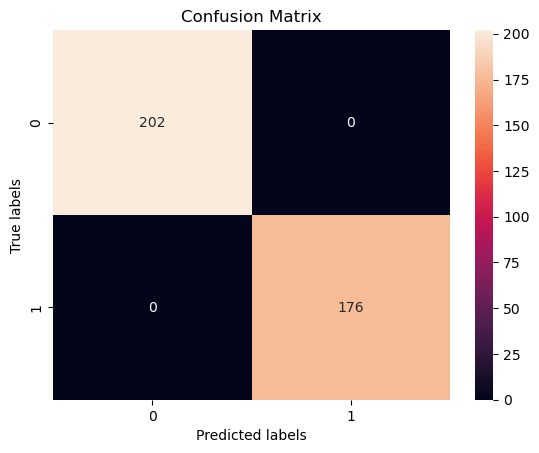

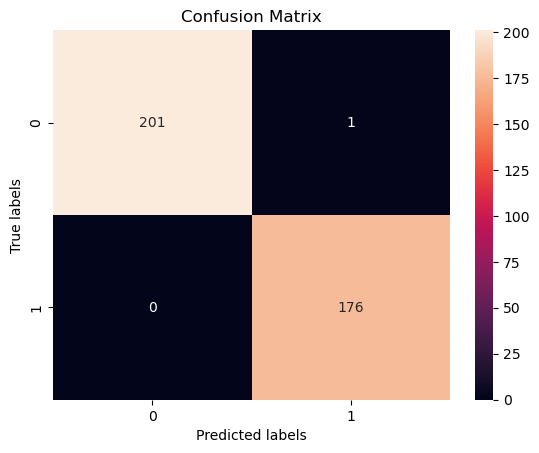

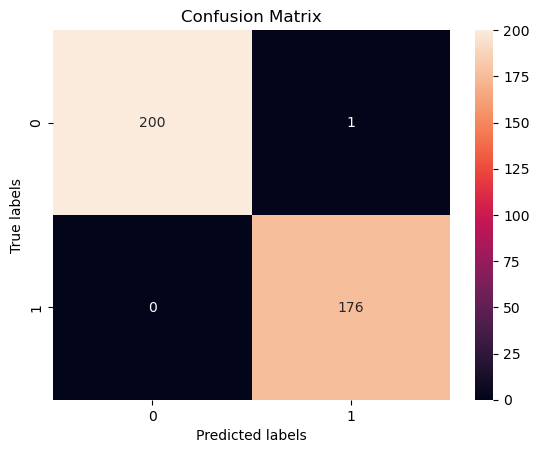

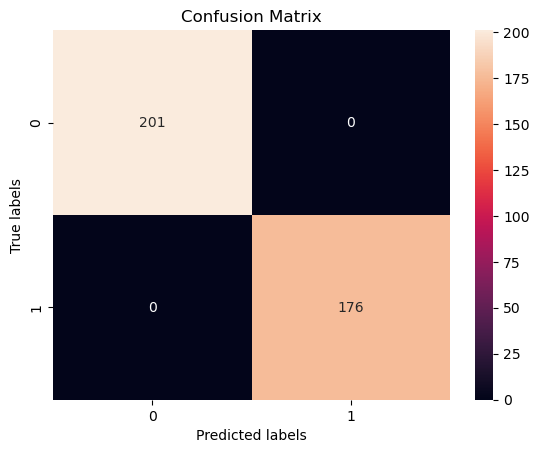

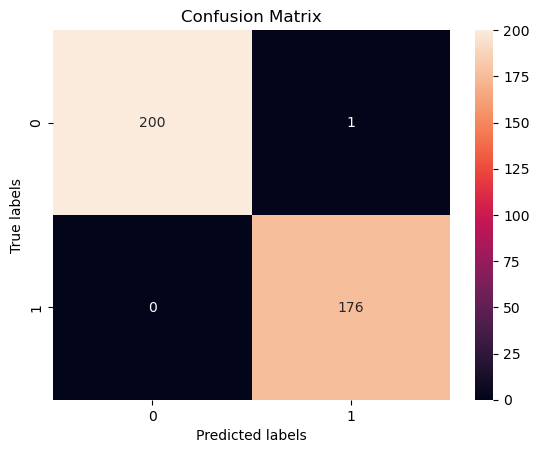

In [62]:
# Plot the confusion matrix values for each fold on the same graph
for cm in confusion_matrices:
    ax= pyplot.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    pyplot.show() 

# Show the plot
plt.show()

In [63]:
pyplot.rcParams.update({'font.size': 8})

In [ ]:
tprs = []
base_fpr = np.linspace(0, 1, 101)
pyplot.figure(figsize=(10, 10))
pyplot.axes().set_aspect('equal', 'datalim')

For fold 1 optimal Threshold=0.799534, G-Mean=1.000
For fold 2 optimal Threshold=0.925962, G-Mean=1.000
For fold 3 optimal Threshold=0.799280, G-Mean=1.000
For fold 4 optimal Threshold=0.237776, G-Mean=1.000
For fold 5 optimal Threshold=0.164734, G-Mean=1.000
mean Threshold=1.000000, G-Mean=0.995


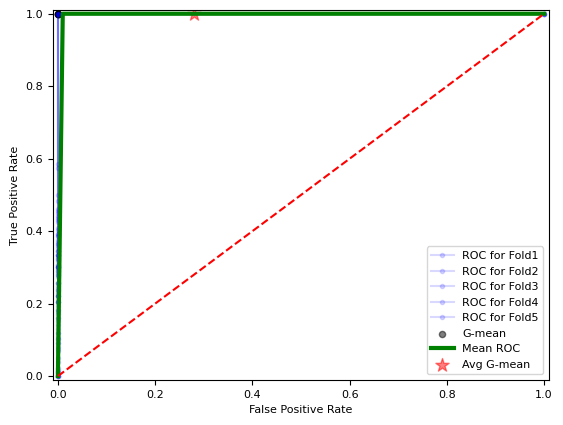

In [73]:
# Plot the ROC and precision-recall values for each fold on the same graph
tprs = []

# Calculate the mean values of FPR and TPR for the ROC curve
mean_fpr = sum(fpr[i] for i in range(len(roc_values))) / len(roc_values)
mean_tpr = sum(tpr[i] for i in range(len(roc_values))) / len(roc_values)

# Calculate the mean values of precision and recall for the precision-recall curve
mean_precision = sum(precision[i] for i in range(len(precision_recall_values))) / len(precision_recall_values)
mean_recall = sum(recall[i] for i in range(len(precision_recall_values))) / len(precision_recall_values)

i = 1
j = 1
    
# ROC CURVE
for fpr, tpr,thresholds in roc_values:
    
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    print('For fold '  +str(i), 'optimal Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr,'b', alpha=0.15, marker='.', label='ROC for Fold' +str(i))
    
    tpr_new = np.interp(base_fpr, fpr, tpr)
    tpr_new[0] = 0.0
    tprs.append(tpr_new)
    
   
    if i == num_folds:
        pyplot.scatter(fpr[ix], tpr[ix],s=20,alpha=0.5, marker='o', color='black', label='G-mean')
        pyplot.legend()
    else:
        pyplot.scatter(fpr[ix], tpr[ix],s=20,alpha=0.5, marker='o', color='black')  
        pyplot.legend()
        
    i = i + 1
     
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


gmeans_new = sqrt(mean_tprs * (1-base_fpr))
# locate the index of the largest g-mean
iy = argmax(gmeans_new)
print('mean Threshold=%f, G-Mean=%.3f' % (thresholds[iy], gmeans_new[iy]))

pyplot.plot(base_fpr, mean_tprs, 'g',linewidth=3.0, label='Mean ROC')
pyplot.scatter(base_fpr[ix], mean_tprs[ix],s=100,alpha=0.5, marker="*", color='Red', label='Avg G-mean')
pyplot.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

pyplot.plot([0, 1], [0, 1],'r--')
pyplot.xlim([-0.01, 1.01])
pyplot.ylim([-0.01, 1.01])
pyplot.ylabel('True Positive Rate')
pyplot.xlabel('False Positive Rate')
pyplot.legend()
pyplot.show()



In [66]:
prc = []
base_recall = np.linspace(0, 1, 101)

For fold 1 Best Threshold=0.799534, F-Score=1.000
For fold 2 Best Threshold=0.925962, F-Score=1.000
For fold 3 Best Threshold=0.799280, F-Score=1.000
For fold 4 Best Threshold=0.237776, F-Score=1.000
For fold 5 Best Threshold=0.164734, F-Score=1.000


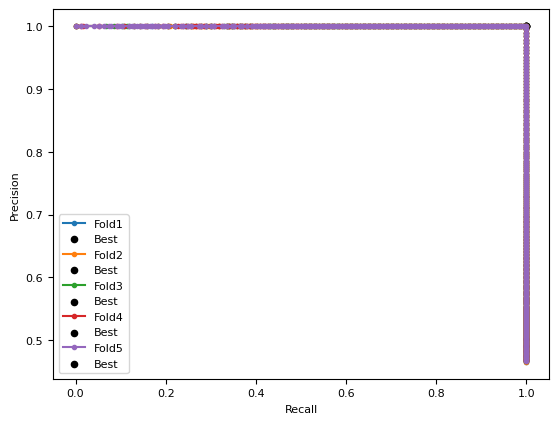

In [80]:
ix = 0 
j = 1
# PRECISION RECALL CURVE
for precision, recall, thresholds_1 in precision_recall_values:
    
     # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('For fold '  +str(j),'Best Threshold=%f, F-Score=%.3f' % (thresholds_1[ix], fscore[ix]))

    pyplot.plot(recall, precision, marker='.', label='Fold' + str(j))
    
    pyplot.scatter(recall[ix], precision[ix],s=20, marker='o', color='black', label='Best')
    # axis labels

    j = j + 1

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
    
# Show the plot
pyplot.show()

In [81]:
ypred = mdl.predict(X_tst).ravel()
threshold = 0.10
pd.crosstab(test_part_df['event'], ypred >= threshold)

1/1 [==============================] - 0s 22ms/step


col_0,True
event,
Dummy,26
